Adaptado de [*Speech and Language Processing. Daniel Jurafsky & James H. Martin*](https://web.stanford.edu/~jurafsky/slp3/5.pdf)

### Función sigmoide
$
\text{sigmoid}(z) = \frac{1}{1 + e^{-x}}
$

In [ ]:
import numpy as np
def sigmoid(x):
    """
    Compute the sigmoid function.

    The sigmoid function takes an input and returns a value between 0 and 1,
    representing the probability of the input belonging to the positive class.

    Parameters:
    - x: float or array-like, input value(s).

    Returns:
    - sigmoid_val: float or array-like, result of applying the sigmoid function to x.
    """
    sigmoid_val = 1 / (1 + np.exp(-x))
    return sigmoid_val

### Función costo

$L_{CE}(\hat{y}, y) = −log\ p(y|x) = −[ y\ log\  \hat{y} + (1 − y)\ log(1−\hat{y})]$

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    """
    Calculates the cross-entropy loss between the true values and predicted values.

    Parameters:
    - y_true: Array-like, true values.
    - y_pred: Array-like, predicted values.

    Returns:
    - loss: float, cross-entropy loss.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    epsilon = 1e-7  # small value to avoid division by zero
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip values to avoid logarithm of zero

    sample_size = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

Prueba

In [ ]:
y_true = np.array([1,0,1,0]).reshape(-1,1) # Cuatro ejemplos de entrenamiento en una matriz de (4,1)
y_pred = np.array([0.2,0.8,0,1]).reshape(-1,1) # Valores predichos, en una matriz de la misma estructura

print(round(cross_entropy_loss(y_true,y_pred),2))

y_pred = np.array([0.6,0.01,0.8,0.0003]).reshape(-1,1) # Redefinimos y_pred
print(round(cross_entropy_loss(y_true,y_pred),2))

## Descenso de gradiente

$\hat{\theta} = \arg\min_{\theta} \frac{1}{m} \sum_{i=1}^{m} L_{CE}(f(x^{(i)}; \theta), y^{(i)})$

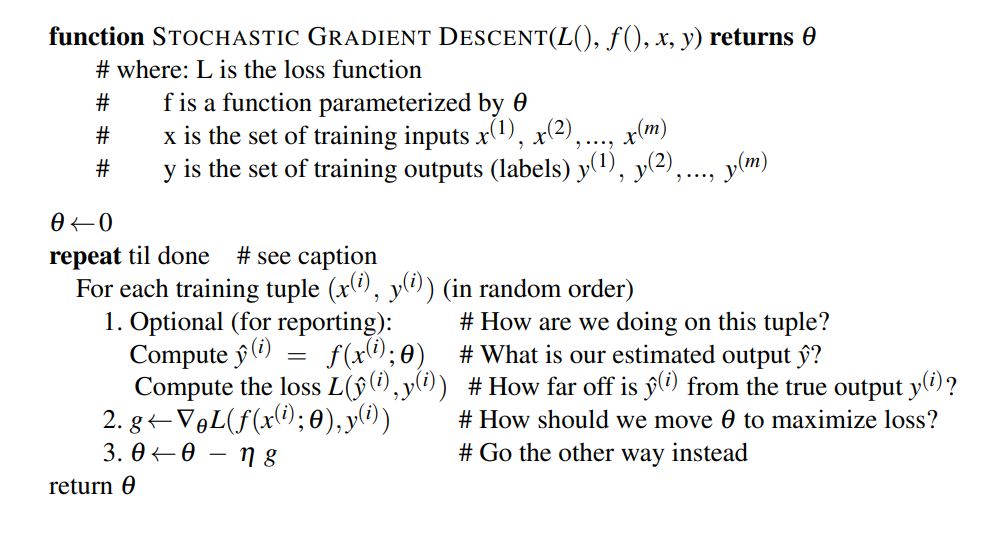



In [ ]:
def get_prediction(X, w):
    z = np.dot(X, w)
    y_preds = sigmoid(z)
    return y_preds

n = 2 # cantidad de features
m = 4 # ejemplos de entrenamiento

x = np.random.rand(m,n) # las filas son los ejemplos de entrenamiento, las columnas son los features de cada ejemplo
w = np.random.rand(n,1) # column vector: multiple rows and single column; las filas son los features

get_prediction(x,w)

In [ ]:
def compute_gradient(X, w, y_true, get_prediction_func):
    m = X.shape[0]  # Number of training examples

    # Compute the predicted probabilities
    y_pred = get_prediction_func(X,w)

    # Compute the gradient of the log-likelihood function
    gradient = np.dot(X.T, y_pred - y_true) # Esta fórmula está "hardcodeada"

    return gradient/m

y_trues = np.zeros(m).reshape(m,1)
compute_gradient(x,w,y_trues,get_prediction)

In [ ]:
def gradient_descent(L, f, X, y_trues, epochs=5, learning_rate=0.1):
    # L is the loss function
    # f is a function parameterized by θ que retorna el valor de la predicción
    # X is the matrix of training inputs [x(1), x(2), ..., x(m)]
    # Y is the matrix of training outputs (labels) [y(1), y(2), ..., y(m)]
    w = np.zeros(X.shape[1]).reshape(X.shape[1],1)
    m = X.shape[0]

    for iteration in range(epochs):
        # Compute the predicted outputs for the entire training set
        y_preds = f(X, w)

        # Compute the loss L(y_hat, Y)
        loss = L(y_preds, y_trues)
        print(f'Costo en la iteración {iteration}: {loss}\n')

        # Compute the gradient ∇θ L(f(X; θ), Y)
        gradient = compute_gradient(X, w, y_trues, f)
        print(f'Gradiente:\n{gradient}\n')
        # Update θ using the learning rate η and the gradient
        w = w - learning_rate * gradient

    return w

## Ejemplo de la página 17

In [ ]:
x = np.array([[3,2]])
y_trues = np.array([[1]])

gradient_descent(L=cross_entropy_loss,f=get_prediction,X=x,y_trues=y_trues,learning_rate=0.1,epochs=1)

Note in these equations that the gradient with respect to a single weight wj represents a very intuitive value: the difference between the true y and our estimated yˆ = σ(w·x+b) for that observation, multiplied by the corresponding input value xj.

# [Word2Vec](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

In [ ]:
m = 10 # vocabulario
n = 5 # features

w = np.zeros((m,n))
v = np.zeros((m,n))
x = np.zeros((m,m))


$c_{t+1}^{pos} = c_{t}^{pos} - \eta \left[ \sigma(c_{t}^{pos} \cdot w_{t}) - 1 \right]w$<br><br>
$c_{t+1}^{neg} = c_{t}^{neg} - \eta \left[ \sigma(c_{t}^{neg} \cdot w_{t}) \right]w_{t}$<br><br>
$w_{t+1} = w_{t} - \eta \left[ \sigma(c_{pos} \cdot w_{t}) - 1 \right]c_{pos} + \sum_{i=1}^{k} \left[ \sigma(c_{neg_i} \cdot w_{t}) \right]c_{neg_i}$

In [319]:
import numpy as np
from collections import defaultdict
import random
from IPython.display import clear_output

class Word2Vec:
    def __init__(self, context_window=2, num_dimensions=5, learning_rate=0.1, num_negative_samples=2):
        self.num_dimensions = num_dimensions
        self.context_window = 2
        self.learning_rate = learning_rate
        self.num_negative_samples = num_negative_samples
        self.W = None
        self.V = None

    def normalize(self,string):
      return string.strip().lower()

    def initialize_weights(self, vocabulary_size):
        self.W = np.random.uniform(-0.5 / self.num_dimensions, 0.5 / self.num_dimensions, (vocabulary_size, self.num_dimensions))
        self.V = np.zeros((vocabulary_size, self.num_dimensions))

    def train(self, corpus, num_epochs):

        losses = list()

        self.count = 0
        self.last_print = ''
        self.num_epochs = num_epochs

        self.build_vocabulary(corpus)
        vocabulary_size = len(self.vocabulary)
        self.initialize_weights(vocabulary_size)
        for epoch in range(self.num_epochs):
            self.total_loss = 0.0
            for target, context, negative_samples in self.generate_training_data(corpus):
                self.update_weights(target, context, negative_samples)
            losses.append(self.total_loss)
            #if len(losses) > 1 and self.total_loss > losses[-2]:
            #  break
            print(f"Loss at epoch {epoch}: {self.total_loss}")

    def build_vocabulary(self, corpus):
        self.vocabulary = set()
        for sentence in corpus:
            for word in sentence.split():
              self.vocabulary.add(word)
        self.vocabulary = list(self.vocabulary)

    def print_progress(self,len_corpus):
        self.count += 1
        trained = round((self.count/len_corpus)*100)
        if trained != self.last_print:
          clear_output(wait=True)
          print(f'{trained}% procesado',flush=True)
          self.last_print = trained

    def generate_training_data(self, corpus):
        for sentence in corpus:
            self.print_progress(len(corpus)*self.num_epochs)
            for target_idx, target in enumerate(sentence.split()):
                context = self.get_context(sentence, target_idx)
                negative_samples = self.get_negative_samples(context)
                yield target, context, negative_samples

    def get_context(self, sentence, target_idx):
        context = []
        sentence = sentence.strip().split()
        for i in range(target_idx - self.context_window, target_idx + self.context_window):
            if i != target_idx and i >= 0 and i < len(sentence): # si no hay las suficientes palabras, se usan menos
                context.append(sentence[i])
        return context

    def get_negative_samples(self, context):
        negative_samples = []
        while len(negative_samples) < self.num_negative_samples:
            sample = random.choice(self.vocabulary)
            if sample not in context:
                negative_samples.append(sample)
        return negative_samples

    def update_weights(self, target, context, negative_samples):
        for context_word in context:
            error = self.compute_error(target, context_word, 1)
            self.total_loss -= error
            self.update_weights_for_word(target, context_word, error)

            for negative_word in negative_samples: # más de un negative sample por context word
                error = self.compute_error(target, negative_word, 0)
                self.total_loss -= error
                self.update_weights_for_word(target, negative_word, error)

    def compute_error(self, target, context_word, label):
        '''
        Esto calcula el gradiente de la función costo respecto de W (target) y de C (context, puede ser un negative sample)
        Con las context_words el true label es 1, y el algoritmo tiene que aproximar el producto punto (para que sean similares
        según el coseno); con las negative words el true label es 0, y el costo es mayor si la predicción se acerca a 1
        '''
        target_vector = self.W[self.vocabulary.index(target)]
        context_vector = self.V[self.vocabulary.index(context_word)]
        dot_product = np.dot(target_vector, context_vector) # producto punto
        sigmoid = self.sigmoid(dot_product) # valor predicho
        return self.learning_rate * (label - sigmoid) # 1-p en las context words; 0-p en los negative samples. La diferencia respecto del true label

    def update_weights_for_word(self, target, word, error):
        self.W[self.vocabulary.index(target)] += error * self.V[self.vocabulary.index(word)]
        self.V[self.vocabulary.index(word)] += error * self.W[self.vocabulary.index(target)]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def get_word_vector(self,word):
      if word in self.vocabulary:
        return self.W[self.vocabulary.index(word)].reshape(1,-1)
      else:
        print(f"{word} no está en el vocabulario.")

    def compute_most_similar_words(self, word, top_k=5):
        word_vector = self.get_word_vector(self.normalize(word))

        if word_vector is None:
            return []

        similarities = np.dot(self.W, word_vector.T)
        top_indices = np.argsort(similarities, axis=0)[::-1][:top_k]
        #return top_indices
        similar_words = [self.vocabulary[idx] for idx in top_indices.flatten() if idx != self.vocabulary.index(word)]
        return similar_words

In [210]:
word2vec_ = Word2Vec(context_window=2, num_dimensions=10, learning_rate=0.1, num_negative_samples=2)
word2vec_.train(['hola como','hey como estas'],5)

100% processed. Loss:1.4973417495922754


In [299]:
import re
with open('facundo.txt','r') as f:
  corpus = f.read()
corpus = re.sub(r'(?<!\n)\n(?!\n)',' ', corpus)
corpus = corpus.lower()
corpus = re.sub(r'("|,|:|;|_|\n|\*)','',corpus)
corpus = corpus.split('.')

In [ ]:
word2vec = Word2Vec(context_window=2, num_dimensions=25, learning_rate=0.05, num_negative_samples=2)
word2vec.train(corpus[:500],num_epochs=90)

In [327]:
word2vec.compute_most_similar_words('rosas',top_k=50)

['facundo',
 'bien',
 'caudillo',
 'él',
 'general',
 'elemento',
 'obra',
 '«la',
 'leguas',
 'tarde',
 'unitario',
 'trabajo',
 'años',
 'bajo',
 'todo',
 'adversario',
 'momento',
 'muerto',
 'sobre',
 'argentino',
 'ser',
 'improvisado',
 'campos',
 'familias',
 'caballo',
 'político',
 'muy',
 'hizo',
 'decir',
 'cual',
 'debe',
 'sus',
 'asociación',
 'estos',
 'poco',
 'mundo',
 'formado',
 'scott',
 'hacer',
 'espeso',
 'distancia',
 'pueblos',
 'ellos',
 'siempre',
 'antiguo',
 'ciudad',
 'sabe',
 'arriba',
 'mitre']

In [326]:
from google.colab import files

# Save the matrix to a file
file_path = 'word2vec.npy'
np.save(file_path, word2vec.W)

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
matrix = np.load(file_name)